## App Store Reivew analysis - weverse
---------------

## 개요

### 문서 목적
- **beNX**에서 서비스 중인 **weverse** 앱에 대한 분석 리포트 작성을 위해 문서를 만들었습니다.

### 분석 대상
- **구글 플레이 스토어에 고객이 작성한 리뷰 정보**
  - user_name : 이용자 이름(닉네임)
  - user_app_rating : 별점(1~5)
  - user_review_date : 리뷰 작성 날짜
  - company_comment_date : 답변 작성 날짜
  - user_simple_comment : 리뷰 내용
  - user_specific_comment : 리뷰 상세 내용
    - user_simple_comment의 내용이 길 경우 웹 상에서 다 보이지 않고 상세하게 볼 수 있도록 구성되어 있어 추가한 항목입니다. 전처리를 통해 처리 될 예정입니다.
  - company_answer_check : 답변 여부


### 분석 일시
- 크롤링 데이터 구성 시간 : 2019년 10월 06일
- 데이터 분석 시작 : 2019년 10월 06일
- 데이터는 2019-06-11 부터 2019-10-06 기록으로 구성되어 있습니다.

### 분석 방법
1. 데이터 확인
  - 데이터 전처리
  - 컬럼 확인
2. 시간 기록에 따른 데이터 분석
  - 시간에 따른 별점 변화(별점은 1 ~ 5의 값을 가진다)
  - 요일에 따른 리뷰 분석
  - 답변 시간차(고객 응대 소요 시간)
3. 리뷰 내용에 대한 자연어 분석
  - 리뷰 내용을 Topic modeling로 구성하고 시각화
  - 별점에 따라 주요 키워드 분석 진행

### 분석 환경, 분석자
- 분석 환경
  - language
      - python3
  - library
      - [khaiii](https://github.com/kakao/khaiii) : 카카오에서 제공하는 형태소 분석기
      - [gensim](https://radimrehurek.com/gensim/) : 자연어 처리 방법 중 LDA - Topic Modeling 사용
      - 시각화, 데이터 분석을 위한 Python library

- 분석자
  - github : https://github.com/timetobye


### 안내 사항
- **분석에 사용 될 리뷰 정보는 직접 크롤링**을 하여 데이터 셋을 구성하였습니다.
- 2018년 10월 한국 시장 기준으로 Android(72.2%) vs IOS(27.8%)의 점유율을 갖고 있어서 구글 플레이 스토어를 선택하였습니다.
  - [참고 링크 - Difference in Mobile OS Market Share is notable in US, Japan and South Korea](https://en.appa.pe/whitepaper/2018/)
  
--------------------------------------------

### 분석 결과

- 총평 : 그냥 여기 무조건 좋습니다.
- 결과는 PDF로 정리되었습니다. 업로드는 미정
----------------

### code

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.style as style
import seaborn as sns
import khaiii
import missingno as msno
import warnings
import re
import calendar
import gensim
import os
from collections import Counter
from datetime import datetime
from gensim import corpora
from gensim import models
from gensim.models import LdaModel
from pyLDAvis import gensim as gensimvis
from pyLDAvis import display
from pyLDAvis import save_html as lda_visualization
from khaiii import KhaiiiApi
from matplotlib import font_manager, rc
apple = font_manager.FontProperties(fname = '/Library/Fonts/AppleGothic.ttf').get_name()
rc('font', family = apple)

warnings.filterwarnings('ignore')
style.use('fivethirtyeight')
%matplotlib inline

## 1. 데이터 확인

### 데이터 전처리 - Preprocessing

In [3]:
# read_csv to make dataframe

google_playstore_user_review_orginal_df = pd.read_csv('review_data/weverse_app_user_reviews_2019-10-06.csv')
google_playstore_user_review_orginal_df.head(10)

,user_name,user_app_rating,user_review_date,company_comment_date,user_simple_comment,user_specific_comment,company_answer_check
0,김시연,2,2019년 9월 30일,no_answer,영상보는데 엄청끊기고..하아..답답해답답해ㅠㅠㅠㅠ 영상좀안끊겼으면제발...ㅠㅠㅠㅠㅠ...,no_specific_comment,no_answer
1,수현,3,2019년 9월 25일,no_answer,아티스트랑 소통하고 같은 버디분들이랑 소통하는거 다 좋은데 사진이 자꾸 안뜹니다ㅠㅜ...,no_specific_comment,no_answer
2,방탄이 하버드보라해,1,2019년 10월 2일,no_answer,별 하나도 주기아까워요;;;이메일 전송 뭐 어쩌자는거죠? 이메일 전송되지도 않고 가...,no_specific_comment,no_answer
3,박소연,5,2019년 9월 22일,no_answer,이 앱을 사용하니깐 많이 좋아요 근데 몇까지만 해결 해주셨으면 좋겠어요 1신고 기능...,이 앱을 사용하니깐 많이 좋아요 근데 몇까지만 해결 해주셨으면 좋겠어요 1신고 기능...,no_answer
4,SUGA LOVE-슙슙이,5,2019년 10월 6일,no_answer,아티스트와 소통할 수 있어서 엄청 좋아요!,no_specific_comment,no_answer
5,방소단처돌이,2,2019년 10월 6일,no_answer,저 방탄소년단이랑 투모로우바이투게더 둘 다 가입했는데요 1. 글을 쓸 때 내가 방탄...,저 방탄소년단이랑 투모로우바이투게더 둘 다 가입했는데요 1. 글을 쓸 때 내가 방탄...,no_answer
6,김선미,5,2019년 10월 5일,no_answer,🙆‍♀️🙆‍♂️💜,no_specific_comment,no_answer
7,현정,5,2019년 10월 4일,no_answer,너무 좋아여💜💜,no_specific_comment,no_answer
8,Annie. J,5,2019년 10월 4일,no_answer,좋아요.방탄때문에 가입,no_specific_comment,no_answer
9,례쁨이,5,2019년 10월 4일,no_answer,너무 방탄소년단이 조아영,no_specific_comment,no_answer


In [4]:
# check dataframe info

google_playstore_user_review_orginal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 7 columns):
user_name                1502 non-null object
user_app_rating          1502 non-null int64
user_review_date         1502 non-null object
company_comment_date     1502 non-null object
user_simple_comment      1502 non-null object
user_specific_comment    1502 non-null object
company_answer_check     1502 non-null object
dtypes: int64(1), object(6)
memory usage: 82.2+ KB


### check-point

- 크롤링 과정에서도 첫 3개가 시간 순서 정렬과 관계없이 항상 고정된 값으로 구성되어 있었다.
  - 해당 부분에 대해서는 날짜 기준으로 정렬할 것
- 중복 값이 있는 경우를 방지하기 위해 중복 체크도 진행한다.
- 날짜 정보도 사용하기 쉽게 YYYY-MM-DD 형식으로 처리 할 것
- 요일 정보를 얻기 위해 작업을 진행 할 것
- user의 comment를 정리하기 위해 user_comment 컬럼을 추가하고 아래와 같이 진행
  - user_specific_comment가 있을 경우 user_comment로 처리
  - user_specific_comment가 없을 경우 user_simple_comment가 user_comment로 처리


In [69]:
def sort_dataframe(df):
    sorted_df = df.sort_values(by='user_review_date', ascending=False).reset_index(drop=True)
    
    return sorted_df

def drop_duplicate_dataframe(df):
    drop_dp_df = df.drop_duplicates()
    drop_dp_df.reset_index(drop=True, inplace=True)
    
    return drop_dp_df

def get_weekday(date):
    if date == 'no_answer':
        return date
    
    weekday_info_dict = {
        0 : 'Mon',
        1 : 'Tue',
        2 : 'Wed',
        3 : 'Thu',
        4 : 'Fri',
        5 : 'Sat',
        6 : 'Sun'
    }
    
    regex = re.compile(r'[0-9]+')
    get_regex_date = regex.findall(date)
    
    year, month, day = [int(value) for value in get_regex_date]
    
    weekday_number = calendar.weekday(year, month, day)
    weekday_value = weekday_info_dict[weekday_number]
    
    return weekday_value

def convert_date_format(date):
    if date == 'no_answer':
        return date
    
    regex = re.compile(r'[0-9]+')
    get_regex_date = regex.findall(date)

    if len(get_regex_date[1]) == 1:
        get_regex_date[1] = '0' + get_regex_date[1]
        
    if len(get_regex_date[2]) == 1:
        get_regex_date[2] = '0' + get_regex_date[2]
    
    join_string = '-'
    convert_date = join_string.join(get_regex_date)
    
    return convert_date

def arrange_user_comment(df):
    user_comment = []
    
    for index, row in df.iterrows():    
        if row['user_specific_comment'] == 'no_specific_comment':
            user_comment.append(row['user_simple_comment'])
        else:
            user_comment.append(row['user_specific_comment'])

    df['user_comment'] = user_comment
    df.drop(['user_simple_comment', 'user_specific_comment'], axis=1, inplace=True)
    df = df[['user_name', 'user_app_rating', 'user_review_date', 'company_comment_date', 'user_review_weekday', 'user_comment', 'company_answer_check']]
    
    return df

def user_data_preprocessing(google_playstore_user_review_orginal_df):
    # sort user_review_date
    sorted_user_review_df = sort_dataframe(google_playstore_user_review_orginal_df)

    # drop duplicate
    drop_dp_user_review_df = drop_duplicate_dataframe(sorted_user_review_df)

    # get weekday from user_review_date
    drop_dp_user_review_df['user_review_weekday'] = drop_dp_user_review_df['user_review_date'].apply(get_weekday)

    # convert_date_format for applying function in pandas
    drop_dp_user_review_df['user_review_date'] = drop_dp_user_review_df['user_review_date'].apply(convert_date_format)
    drop_dp_user_review_df['company_comment_date'] = drop_dp_user_review_df['company_comment_date'].apply(convert_date_format)

    # arrange_user_comment
    arranged_user_review_df = arrange_user_comment(drop_dp_user_review_df)
    
    return arranged_user_review_df

In [70]:
arranged_user_review_df = user_data_preprocessing(google_playstore_user_review_orginal_df)
arranged_user_review_df.head()

,user_name,user_app_rating,user_review_date,company_comment_date,user_review_weekday,user_comment,company_answer_check
0,나도아미,1,2019-09-09,no_answer,Mon,로그인안되서 비번바꾸려고 계속 이메일로 전송됐다고 하는데 지금며칠째 메일도 안옵니다...,no_answer
1,지민쒜,1,2019-09-08,no_answer,Sun,아미분들중에 멤버들을 존중하시지 않는 분들이 많네요 그것때문에 애들 상처 받고 그러...,no_answer
2,정민주의브이로그,5,2019-09-08,no_answer,Sun,너무 좋아요^^,no_answer
3,임하리,1,2019-09-08,no_answer,Sun,제발~ 메인 화면 위플리처럼 선택하게 해주세요~ 본인이 좋아하는 그룹 외 다른 그룹...,no_answer
4,Wooho Cho,5,2019-09-07,no_answer,Sat,아ㅜㅜㅜㅜ진짜 너무 좋아요ㅜㅜㅜ공카에선 등업해야 볼 수 있는 방탄오빠들 포스트도 그...,no_answer


--------------------------------

## Basic EDA

### check data info & missingvalue

In [71]:
arranged_user_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 7 columns):
user_name               1498 non-null object
user_app_rating         1498 non-null int64
user_review_date        1498 non-null object
company_comment_date    1498 non-null object
user_review_weekday     1498 non-null object
user_comment            1498 non-null object
company_answer_check    1498 non-null object
dtypes: int64(1), object(6)
memory usage: 82.0+ KB


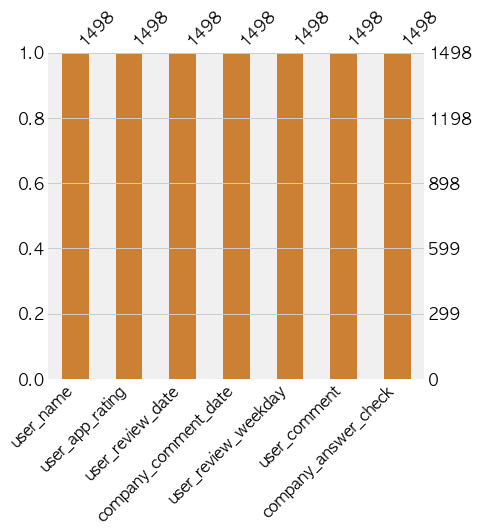

In [72]:
#msno.bar

msno.bar(df=arranged_user_review_df.iloc[:, :], figsize=(6, 6), color=(0.8, 0.5, 0.2))
plt.show()

### 수집된 데이터의 기간

In [73]:
max_date = arranged_user_review_df['user_review_date'].max()
min_date = arranged_user_review_df['user_review_date'].min()

print(f'수집된 데이터를 살펴보니 이용자가 리뷰를 작성한 날짜는 {min_date} 부터 {max_date} 까지 입니다.')

수집된 데이터를 살펴보니 이용자가 리뷰를 작성한 날짜는 2019-06-11 부터 2019-10-06 까지 입니다.


### 리뷰를 작성한 사람들은 누구일까요?

In [74]:
def arrange_count_value(df, column_name):
    df_value_count = df[column_name].value_counts()
    
    df_count = df_value_count.rename_axis('user').reset_index(name='writing_count')
    sorted_df_count = df_count.sort_values('writing_count', ascending=False)
    arranged_df = sorted_df_count.reset_index(drop=True)

    return arranged_df

In [75]:
arrange_count_df = arrange_count_value(arranged_user_review_df, 'user_name')
arrange_count_df.head(10)

,user,writing_count
0,방탄보라해,7
1,김아미,5
2,ᄋᄋ,5
3,Google 사용자,5
4,김서현,4
5,민슈가천재짱짱맨뿡뿡,3
6,민윤기천재짱짱맨뿡뿡,3
7,아미,3
8,유진,3
9,보라,3


- **Google 사용자**가 다수가 나온 이유를 살펴보니, 앱스토어에서 실제로 리뷰 작성자의 이름이 Google 사용자라고 되어 있다.
  - 탈퇴를 했거나, 혹은 익명의 아이디를 처리하는 방식으로 판단된다.
  - 결론적으로 Google 사용자를 잠시 제외하고 살펴보겠다.

In [76]:
drop_arrange_count_df = arrange_count_df[arrange_count_df['user']!='Google 사용자'].reset_index(drop=True)

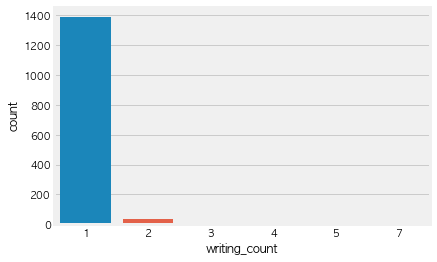

In [77]:
# 이용자들은 개인당 몇 번이나 리뷰를 달았을까?

sns.countplot(x='writing_count', data = drop_arrange_count_df)

In [78]:
groupby_user_review_count = drop_arrange_count_df.groupby('writing_count', as_index=False).count()
groupby_user_review_count.rename(columns = {'user' : 'count'}, inplace=True)
groupby_user_review_count['ratio'] = round(groupby_user_review_count['count']/sum(groupby_user_review_count['count']), 2)
groupby_user_review_count

,writing_count,count,ratio
0,1,1388,0.97
1,2,33,0.02
2,3,6,0.00
3,4,1,0.00
4,5,2,0.00
5,7,1,0.00


- 97%이상의 이용자가 1번 정도의 리뷰를 달았고, 소수의 이용자가 2~3번 리뷰를 달은 것으로 파악된다.

### 어떤 요일에 많이 달았을까?

In [79]:
weekday_count = arrange_count_value(arranged_user_review_df, 'user_review_weekday')
weekday_count.rename(columns={'user' : 'weekday'}, inplace=True)

In [80]:
weekday_count

,weekday,writing_count
0,Tue,408
1,Mon,339
2,Sun,239
3,Wed,174
4,Sat,123
5,Fri,111
6,Thu,104


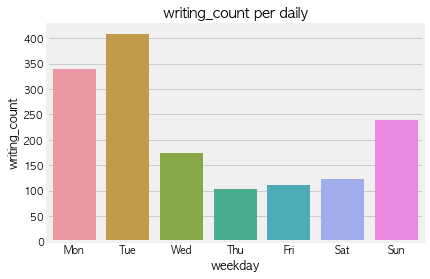

In [81]:
# draw weekday graph

weekday_order_list = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
sns.barplot(x='weekday', y='writing_count', data=weekday_count, order=weekday_order_list)
plt.title('writing_count per daily')
plt.show()

- **화요일**이 가장 높은 리뷰 작성일, **목요일**이 가장 적은 리뷰 작성일인 것을 보여주고 있다.
- 실제 이용 상황은 트래픽을 보고 확인이 가능할 것 같다.

### 별점 분포는 어떻게 되어 있을까?

In [82]:
app_rating_count = arrange_count_value(arranged_user_review_df, 'user_app_rating')
app_rating_count.rename(columns={'user' : 'app_rating', 'writing_count' : 'rating_count'}, inplace=True)
app_rating_count

,app_rating,rating_count
0,5,631
1,1,420
2,4,181
3,3,166
4,2,100


In [83]:
app_rating_count['ratio'] = round(app_rating_count['rating_count']/sum(app_rating_count['rating_count']), 2)
app_rating_count

,app_rating,rating_count,ratio
0,5,631,0.42
1,1,420,0.28
2,4,181,0.12
3,3,166,0.11
4,2,100,0.07


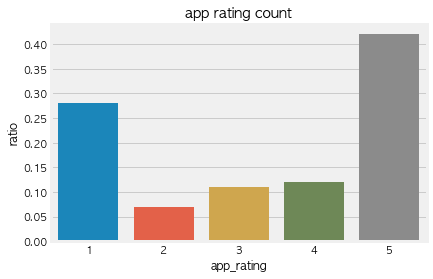

In [84]:
# draw app_rating graph

app_rating_order_list = [1, 2, 3, 4, 5]
sns.barplot(x='app_rating', y='ratio', data=app_rating_count, order=app_rating_order_list)
plt.title('app rating count')
plt.show()

- 5점 42%, 4점 12%, 3점 11%, 2점 7%, 1점 28% 을 이용자들은 리뷰로 남겼다.
- 1점 비율이 심각하게 높은 걸 보면 불만 사항을 파악하고 대응해야 할 필요가 있을 것으로 보인다.

-----------------------

## 2. 시간 기록에 따른 데이터 분석

### 시간에 따른 별점 변화

- 여러가지 접근 방법이 있겠지만, 일별 평균 별점 값을 그래프로 그려서 확인해본다.
- 2019년 10월 06일 기준, 구글 플레이 스토어 별점은 4.6점이다.
- 그래프를 그렸으나 그래프에 표현되는 값이 너무 많은 관계로 2019년 값만 그리도록 하겠습니다.
  - 2019년 06월 11일 부터 2019년 10월 06일까지 기록입니다.

In [109]:
app_rating_with_date = arranged_user_review_df[['user_app_rating', 'user_review_date']]
average_app_rating_per_daily = app_rating_with_date.groupby('user_review_date', as_index=False).mean()
average_app_rating_per_daily = average_app_rating_per_daily[average_app_rating_per_daily['user_review_date']>='2019-01-01']
app_rating_with_date.head()

,user_app_rating,user_review_date
0,1,2019-09-09
1,1,2019-09-08
2,5,2019-09-08
3,1,2019-09-08
4,5,2019-09-07


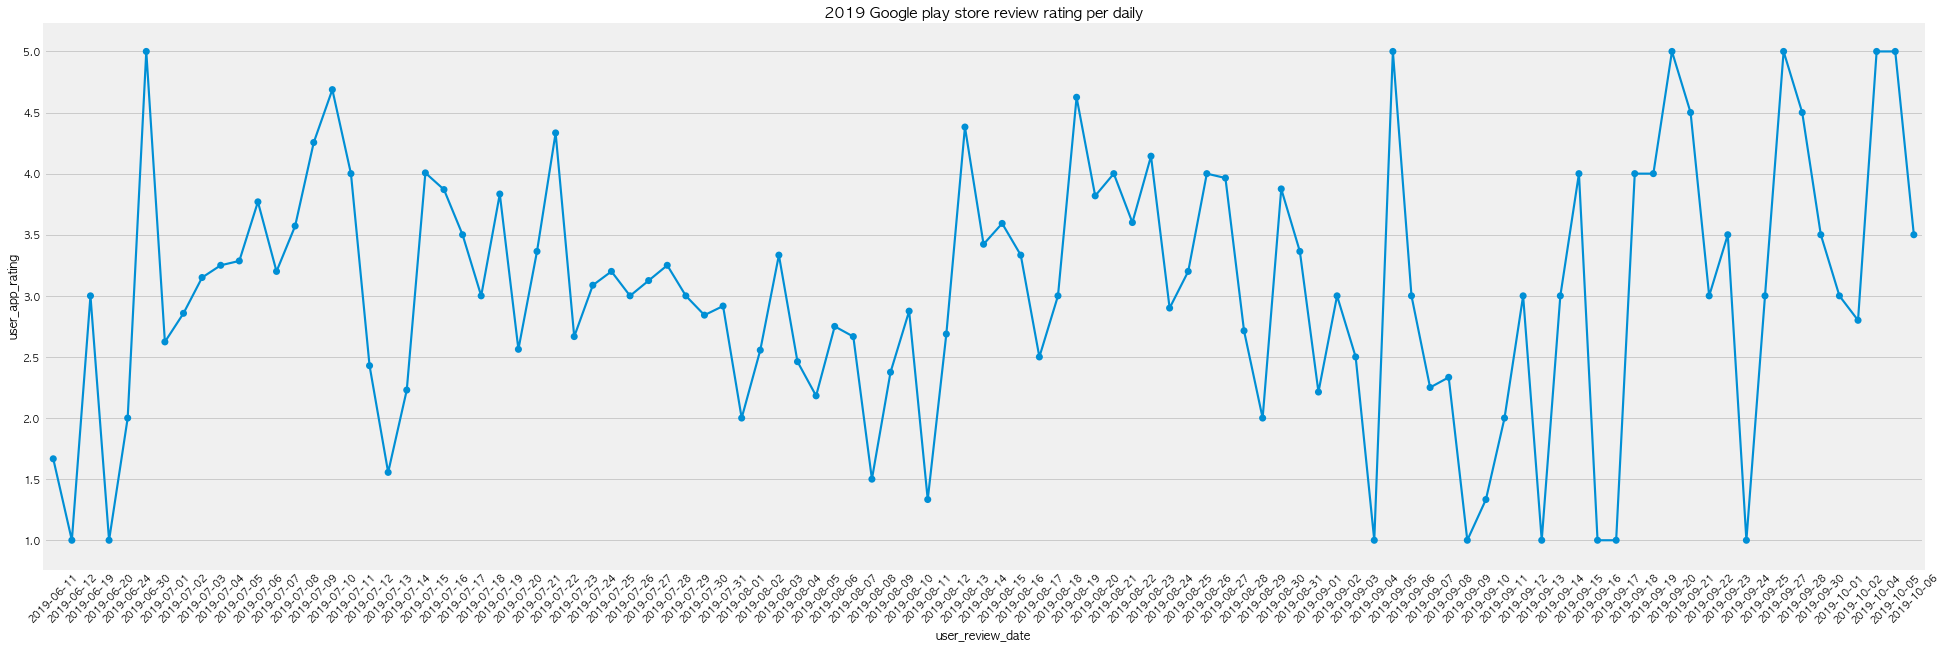

In [110]:
# draw graph : 2019 Google play store review rating per daily

plt.figure(figsize = (30, 10))
sns.pointplot(x='user_review_date', y='user_app_rating', data=average_app_rating_per_daily, scale=0.3)
plt.xticks(rotation=45)
plt.title('2019 Google play store review rating per daily', fontsize = 15)
plt.show()

In [111]:
# check statics

app_rating_with_date.describe()

,user_app_rating
count,1498.000000
mean,3.335781
std,1.697989
min,1.000000
25%,1.000000
50%,4.000000
75%,5.000000
max,5.000000


- 별점 등락이 큰 것으로 보입니다.

### 월별 분석
- 월별 분석을 위해 간단한 전처리 진행 후 분석한다.
  - 단, 월별 분석 과정에서 한 달을 완전히 보존하기 위해 2019년 07월 01일 부터 2019년 09월 30일까지로 한정한다.

In [112]:
app_rating_with_monthly = arranged_user_review_df[['user_app_rating', 'user_review_date']]
app_rating_with_monthly.head()

,user_app_rating,user_review_date
0,1,2019-09-09
1,1,2019-09-08
2,5,2019-09-08
3,1,2019-09-08
4,5,2019-09-07


In [113]:
def extract_year_month(date):
    year_month = date[0:7]
    
    return year_month

In [114]:
app_rating_with_monthly['year_month'] = app_rating_with_monthly['user_review_date'].apply(extract_year_month)
app_rating_with_monthly.head()

,user_app_rating,user_review_date,year_month
0,1,2019-09-09,2019-09
1,1,2019-09-08,2019-09
2,5,2019-09-08,2019-09
3,1,2019-09-08,2019-09
4,5,2019-09-07,2019-09


In [120]:
app_rating_with_year_month = app_rating_with_monthly[(app_rating_with_monthly['year_month']>='2019-07')&(app_rating_with_monthly['year_month']<='2019-09')]
app_rating_with_year_month.sort_values('user_review_date', ascending=False, inplace=True)
app_rating_with_year_month.reset_index(drop=True, inplace=True)

In [121]:
app_rating_with_year_month.head()

,user_app_rating,user_review_date,year_month
0,5,2019-09-30,2019-09
1,2,2019-09-30,2019-09
2,4,2019-09-28,2019-09
3,5,2019-09-28,2019-09
4,5,2019-09-27,2019-09


In [122]:
monthly_result = app_rating_with_year_month.groupby('year_month', as_index=False).mean()
monthly_result

,year_month,user_app_rating
0,2019-07,3.330861
1,2019-08,3.611021
2,2019-09,2.497143


In [123]:
monthly_result.describe()

,user_app_rating
count,3.000000
mean,3.146341
std,0.579411
min,2.497143
25%,2.914002
50%,3.330861
75%,3.470941
max,3.611021


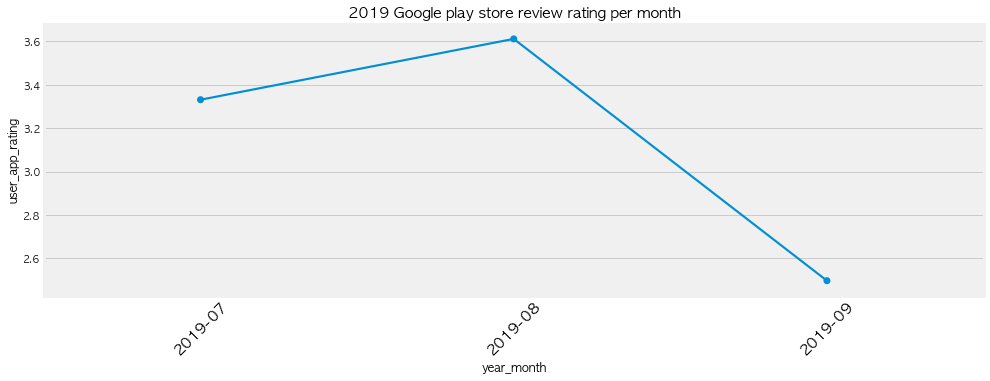

In [124]:
# draw graph : 2019 Google play store review rating per month

plt.figure(figsize = (15, 5))
sns.pointplot(x='year_month', y='user_app_rating', data=monthly_result, scale=0.3)
plt.xticks(rotation=45, fontsize = 15)
plt.title('2019 Google play store review rating per month', fontsize = 15)
plt.show()

- 2019년 01월부터 월별 2.0~3.0의 평점을 받으며 구간 내 반복 중이다.
- 전체 평점 대비 심각하게 낮은 상태이다.

## 요일에 따른 리뷰 분석

In [125]:
weekday_user_review_df = arranged_user_review_df[['user_app_rating', 'user_review_weekday']]
weekday_user_review_df.head()

,user_app_rating,user_review_weekday
0,1,Mon
1,1,Sun
2,5,Sun
3,1,Sun
4,5,Sat


In [126]:
# crosstab for checking two catagory

crosstab_result = pd.crosstab(weekday_user_review_df['user_app_rating'], weekday_user_review_df['user_review_weekday'], margins=True).style.background_gradient(cmap='summer_r')
crosstab_result

user_review_weekday,Fri,Mon,Sat,Sun,Thu,Tue,Wed,All
user_app_rating,,,,,,,,
1,36,80,43,110,33,65,53,420
2,9,18,12,22,6,20,13,100
3,8,38,17,34,12,39,18,166
4,15,39,17,29,18,44,19,181
5,43,164,34,44,35,240,71,631
All,111,339,123,239,104,408,174,1498


In [127]:
# crosstab with ratio

crosstab_result = pd.crosstab(weekday_user_review_df['user_app_rating'], weekday_user_review_df['user_review_weekday'], normalize=True).T
crosstab_result

user_app_rating,1,2,3,4,5
user_review_weekday,,,,,
Fri,0.024032,0.006008,0.005340,0.010013,0.028705
Mon,0.053405,0.012016,0.025367,0.026035,0.109479
Sat,0.028705,0.008011,0.011348,0.011348,0.022697
Sun,0.073431,0.014686,0.022697,0.019359,0.029372
Thu,0.022029,0.004005,0.008011,0.012016,0.023364
Tue,0.043391,0.013351,0.026035,0.029372,0.160214
Wed,0.035381,0.008678,0.012016,0.012684,0.047397


In [128]:
def draw_heatmap(weekday_user_review_df, weekday_order_list):
    crosstab_result = pd.crosstab(weekday_user_review_df['user_app_rating'], weekday_user_review_df['user_review_weekday'], normalize=True).T
    crosstab_result = crosstab_result.reindex(index=weekday_order_list)
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(crosstab_result, cmap="YlGnBu", annot=True, cbar=True, fmt='0.3g')
    plt.title('user_app_rating per weekday')
    plt.show()

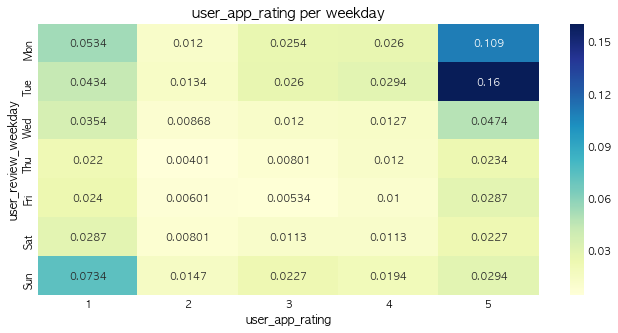

In [129]:
draw_heatmap(weekday_user_review_df, weekday_order_list)

- 특별한 건 없어 보임

In [130]:
# - 일요일에 가장 많은 리뷰 횟수가 기록되면서, 5점 리뷰도 가장 많이 기록되고 있는 것으로 파악된다.
# - 화요일에 가장 적은 리뷰 횟수가 기록되며, 높은 리뷰 점수 비중도 다른 날에 비해 상대적으로 낮다.
  # - 트래픽을 확인 할 수는 없으나, 일요일을 타깃으로 이용자들과 호흡할 수 있는 이벤트도 검토해볼만하다.

---------------------------------

### 고객 응대 소요 시간
- 이용자들에게 답변하는 날짜는 이용자가 리뷰를 달은 날짜와 얼마나 차이가 날까?
  - 답변을 달지 않은 날은 제외하고 파악해보도록 하자
  - 아쉽게도 시, 분, 초는 플레이스토어에서 구할 수가 없어서 day 기준으로 판단한다.
- 리플을 굳이 달지 않아도 되는 항목이 있을 수도 있으니, 리플을 달은 것 vs 달지 않은 것에 대한 비교는 하지 않는다.
- 왠지 느낌적으로 답변도 참 달으셨을 것 같다.

### 답변을 하나도 달지 않았다........;;;;;

In [131]:
reply_date_df = arranged_user_review_df[['user_app_rating', 'user_review_date', 'company_comment_date']]
reply_date_df_with_answer = reply_date_df[reply_date_df['company_comment_date']!='no_answer'].reset_index(drop=True)
reply_date_df_with_answer.head()

,user_app_rating,user_review_date,company_comment_date


In [132]:
def convert_string_to_datetime_format(date):
    convert_date = datetime.strptime(date, "%Y-%m-%d")
    
    return convert_date


def calculate_time_deleta(df, column_name_1, column_name2):
    time_delta_list = []
    for index, row in df.iterrows():
        time_delta_value = row[column_name2] - row[column_name_1]
        time_delta_day = time_delta_value.days
        
        time_delta_list.append(time_delta_day)
        
    df['reply_time'] = time_delta_list
    
    return df

In [133]:
# convert string to datetime_format

reply_date_df_with_answer_columns = ['user_review_date', 'company_comment_date']

for column in reply_date_df_with_answer_columns:
    reply_date_df_with_answer[column] = reply_date_df_with_answer[column].apply(convert_string_to_datetime_format)
    

# calculate time delta

cal_reply_time_delta_df = calculate_time_deleta(reply_date_df_with_answer, 'user_review_date', 'company_comment_date')
cal_reply_time_delta_df.head()

,user_app_rating,user_review_date,company_comment_date,reply_time


In [134]:
def arrange_count_value(df, column_name):
    df_value_count = df[column_name].value_counts()
    
    df_count = df_value_count.rename_axis('reply_time').reset_index(name='count')
    sorted_df_count = df_count.sort_values('reply_time', ascending=True)
    arranged_df = sorted_df_count.reset_index(drop=True)
    arranged_df = sorted_df_count[sorted_df_count['reply_time']>=0].reset_index(drop=True)
    
    return arranged_df

In [135]:
# 답변 시간이 음수가 되는 경우가 종종 있다. 
# 시스템 문제로 파악 되었으나, 그게 아니고 하나의 글에 리플을 여러번 달 경우 처음 답변과의 시차가 발생해서 나타난 결과이다.
# 이번 분석에서는 음수가 되는 경우는 제외하고 시각화 하겠다.

reply_time_df = arrange_count_value(cal_reply_time_delta_df, 'reply_time')
reply_time_df['ratio'] = reply_time_df['count'] / sum(reply_time_df['count'])
reply_time_df['cumsum_ratio'] = reply_time_df['ratio'].cumsum()
reply_time_df = reply_time_df[reply_time_df['reply_time']<=20]

In [136]:
# # draw reply_time graph
# def draw_count_and_ratio_graph(df):
#     y_position = 1.02
#     f, ax = plt.subplots(1,2, figsize=(20, 5))

#     sns.barplot(x='reply_time', y='count', data=df, ax=ax[0])
#     ax[0].set_title(f'reply_time with count')

#     sns.barplot(x='reply_time', y='cumsum_ratio', data=df, ax=ax[1])
#     ax[1].set_title(f'reply_time with cumsum_ratio')
    
#     plt.tight_layout()
#     plt.show()

# draw_count_and_ratio_graph(reply_time_df)

- 크롤링한 데이터에서 답변이 한개도 달려있지 않다.

In [137]:
# filter data set

reply_date_df = arranged_user_review_df[['user_app_rating', 'user_review_date', 'company_comment_date']]
reply_date_df_with_low_rating = reply_date_df[(reply_date_df['company_comment_date']!='no_answer')&(reply_date_df['user_app_rating']<=2)].reset_index(drop=True)
reply_date_df_with_low_rating.head()


# convert string to datetime_format

reply_date_df_with_low_rating_columns = list(reply_date_df_with_low_rating.columns)

for column in reply_date_df_with_low_rating_columns:
    if column == "user_app_rating":
        continue

    reply_date_df_with_low_rating[column] = reply_date_df_with_low_rating[column].apply(convert_string_to_datetime_format)
    

# calculate time delta

cal_reply_time_delta_df = calculate_time_deleta(reply_date_df_with_low_rating, 'user_review_date', 'company_comment_date')


# calculate ratio

reply_time_df = arrange_count_value(cal_reply_time_delta_df, 'reply_time')
reply_time_df['ratio'] = reply_time_df['count'] / sum(reply_time_df['count'])
reply_time_df['cumsum_ratio'] = reply_time_df['ratio'].cumsum()
reply_time_df = reply_time_df[reply_time_df['reply_time']<=20]

In [48]:
# draw_count_and_ratio_graph(reply_time_df)

- 크롤링 데이터에 답변달린 것이 한 개도 없다.
------------------------

### 3. 리뷰 내용에 대한 자연어 간단 분석
- KAKAO KHAiii를 이용하여 명사 추출
- 추출된 자료를 바탕으로 Topic modeling로 구성하고 시각화
- 별점에 따라 주요 키워드 분석 진행

In [49]:
def extract_noun(word_object_list):
    extracted_word_noun_list = []
    
    for i, word_object in enumerate(word_object_list):
        word_object_morphs = word_object.morphs
        
        for word in word_object_morphs:
            if word.tag in ['NNG', 'NNP']:
                extracted_word_noun_list.append(word.lex)
    
    return extracted_word_noun_list


def execute_khaiii(user_comment_list):
    sentence_analyze_components = []
    kha_api = KhaiiiApi()
    
    for i, user_comment in enumerate(user_comment_list):
        word_object_list = []
        user_comment_analyze_objects = kha_api.analyze(user_comment)
        
        for user_comment_analyze_object in user_comment_analyze_objects:
            word_object_list.append(user_comment_analyze_object)
            
        extracted_noun_list = extract_noun(word_object_list)  
        sentence_analyze_components.append(extracted_noun_list)
        
#         if i == 1:
#             break
    
    return sentence_analyze_components

In [50]:
# get user_comment_noun_list of all rating reviews

user_comment_list = arranged_user_review_df['user_comment'].tolist()
all_rating_extracted_user_comment_noun_list = execute_khaiii(user_comment_list)

In [51]:
all_rating_extracted_user_comment_noun_list[0][0:10]

['로', '인안', '비번', '이메일', '전송', '칠', '메', '일', '도', '가입']

In [52]:
def delete_stopwords(word):
    regex = '[ㄱ-ㅎㅏ-ㅣ]+'
    changed_word = re.sub(pattern=regex, repl='None', string=word)
    
    return changed_word

def get_dataframe_from_noun_list(extracted_user_comment_noun_list):
    word_count_dict = {}
    
    for i, word_list in enumerate(extracted_user_comment_noun_list):
        for word in word_list:
            if word not in word_count_dict:
                word_count_dict[word] = 1
            else:
                word_count_dict[word] += 1
                
    word_count_df = pd.DataFrame.from_dict(word_count_dict, orient='index').reset_index().rename(columns = {'index': 'word', 0 : 'count'}).sort_values(by='count', ascending=False).reset_index(drop=True)
    word_count_df['word'] = word_count_df['word'].apply(delete_stopwords)
    word_count_df_new = word_count_df[word_count_df['word']!='None']
    
    return word_count_df_new

def draw_graph(word_count_df_new):
    plt.figure(figsize = (15, 5))
    sns.barplot(x = 'word', y = 'count', data=word_count_df_new[0:15])
    plt.title('high frequency Top 15 words', fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.show()

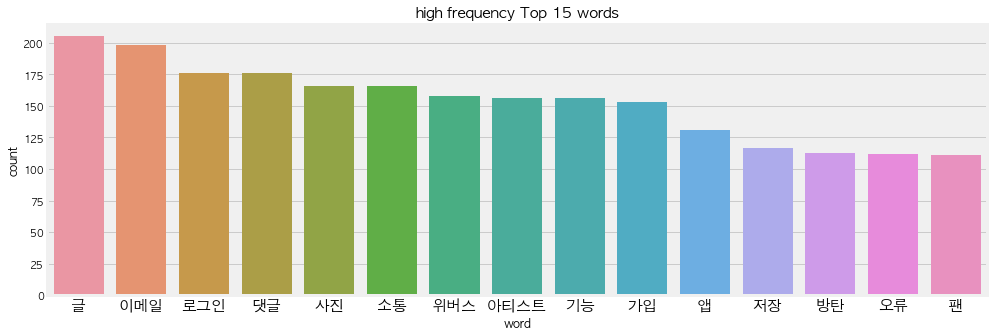

In [53]:
all_rating_word_count_df_new = get_dataframe_from_noun_list(all_rating_extracted_user_comment_noun_list)
draw_graph(all_rating_word_count_df_new)

In [54]:
# Topic Modeling with gensim

def save_model_data(name, folder_name='lda_model'):
    folder_path = f'{os.getcwd()}{"/"}{folder_name}'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    file_path = os.path.join(folder_path, name)

    return file_path


def load_model_data(name, folder_name='lda_model'):
    folder_path = f'{os.getcwd()}{"/"}{folder_name}'
    file_path = os.path.join(folder_path, name)

    return file_path


class ReviewModeling:

    def __init__(self, topic_num=10, rating_type='all_rating'):
        self.topic_num = topic_num
        self.rating_type = rating_type

    def make_train_review_data_list(self, review_text_list):
        #         articles = self._extract_noun(review_text_list)
        cleaned_articles = self._delete_single_word(review_text_list)
        high_frequency_words = self._get_high_frequency_words(cleaned_articles)
        data_list = self._filter_low_frequency_word(cleaned_articles,
                                                    high_frequency_words)

        return data_list

    def make_lda_model(self, data_list):
        self._make_word_dictionary(data_list)
        self._make_doc_matrix(data_list)
        self._make_gensim_model()

    def make_lda_visualization(self):
        file_path = load_model_data('app_review_train_model.model')
        model = LdaModel.load(file_path)
        lda_prepared_data = gensimvis.prepare(model,
                                              self.doc_matrix,
                                              self.review_dictionary)
        
        html_file_name = f'{self.rating_type}_app_review_topic_modeling_visualization.html'

        lda_visualization(lda_prepared_data, html_file_name)
        
        self._make_probability_graph(model)

    def _extract_noun(self, review_text_list):
        mecab = Mecab()
        article_list = []
        for article in review_text_list:
            extracted_noun = mecab.nouns(article)
            article_list.append(extracted_noun)

        return article_list

    def _delete_single_word(self, article_list):
        article_num = 0
        for split_article in article_list:
            article_list[article_num] = list(filter(lambda x: len(x) >= 2, split_article))
            article_num += 1

        return article_list

    def _get_high_frequency_words(self, clean_text):
        article_words = Counter()
        for article in clean_text:
            article_words.update(article)

        common_words_set = article_words.most_common(10000)
        high_frequency_words_set = tuple(word for word, count in common_words_set)

        return high_frequency_words_set

    def _filter_low_frequency_word(self, article_list, high_frequency_words):
        article_num = 0
        compare_words_set = Counter(high_frequency_words)

        for article in article_list:
            count_result_list = []
            article_counter = Counter(article)
            count_result = article_counter & compare_words_set

            for word, value in count_result.items():
                count_result_list.append(word)
            article_list[article_num] = count_result_list
            article_num += 1

        return article_list

    def _make_word_dictionary(self, train_data):
        self.review_dictionary = corpora.Dictionary(train_data)

        review_dict_file_name = save_model_data('app_review.dict')
        self.review_dictionary.save(review_dict_file_name)

    def _make_doc_matrix(self, train_data):
        self.doc_matrix = []
        for doc in train_data:
            doc2bow_result = self.review_dictionary.doc2bow(doc)
            self.doc_matrix.append(doc2bow_result)

        doc_matrix_file_name = save_model_data('review_corpus.mm')
        corpora.MmCorpus.serialize(doc_matrix_file_name, self.doc_matrix)

    def _make_gensim_model(self):
        review_lda = models.ldamodel.LdaModel
        model = review_lda(self.doc_matrix,
                         num_topics=self.topic_num,
                         id2word=self.review_dictionary,
                         passes=100)

        model_file_name = save_model_data('app_review_train_model.model')
        model.save(model_file_name)

        return model
    
    def _make_probability_graph(self, lda_model):
        fig = plt.figure(figsize=(20,30))
        number = self.topic_num
        image_file_name = f'{self.rating_type}_review_topic.png'
        for i in range(number):
            lda_model_dataframe=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob']).set_index('term')

            plt.subplot(5,3,i+1)
            sns.barplot(x='prob', y=lda_model_dataframe.index, data=lda_model_dataframe, label='Cities', palette="GnBu_d")
            plt.xlabel('probability')

        plt.tight_layout()
        plt.savefig(image_file_name) # 그림 파일로 저장
        plt.show()

In [55]:
def make_lda_model_with_news(news_text, topic_num=15, rating_type='all_rating'):
    # make a lda model from news and draw a topic modeling graph.
    data = ReviewModeling(topic_num, rating_type)
    train_data_set = data.make_train_review_data_list(news_text)
    data.make_lda_model(train_data_set)
    data.make_lda_visualization()

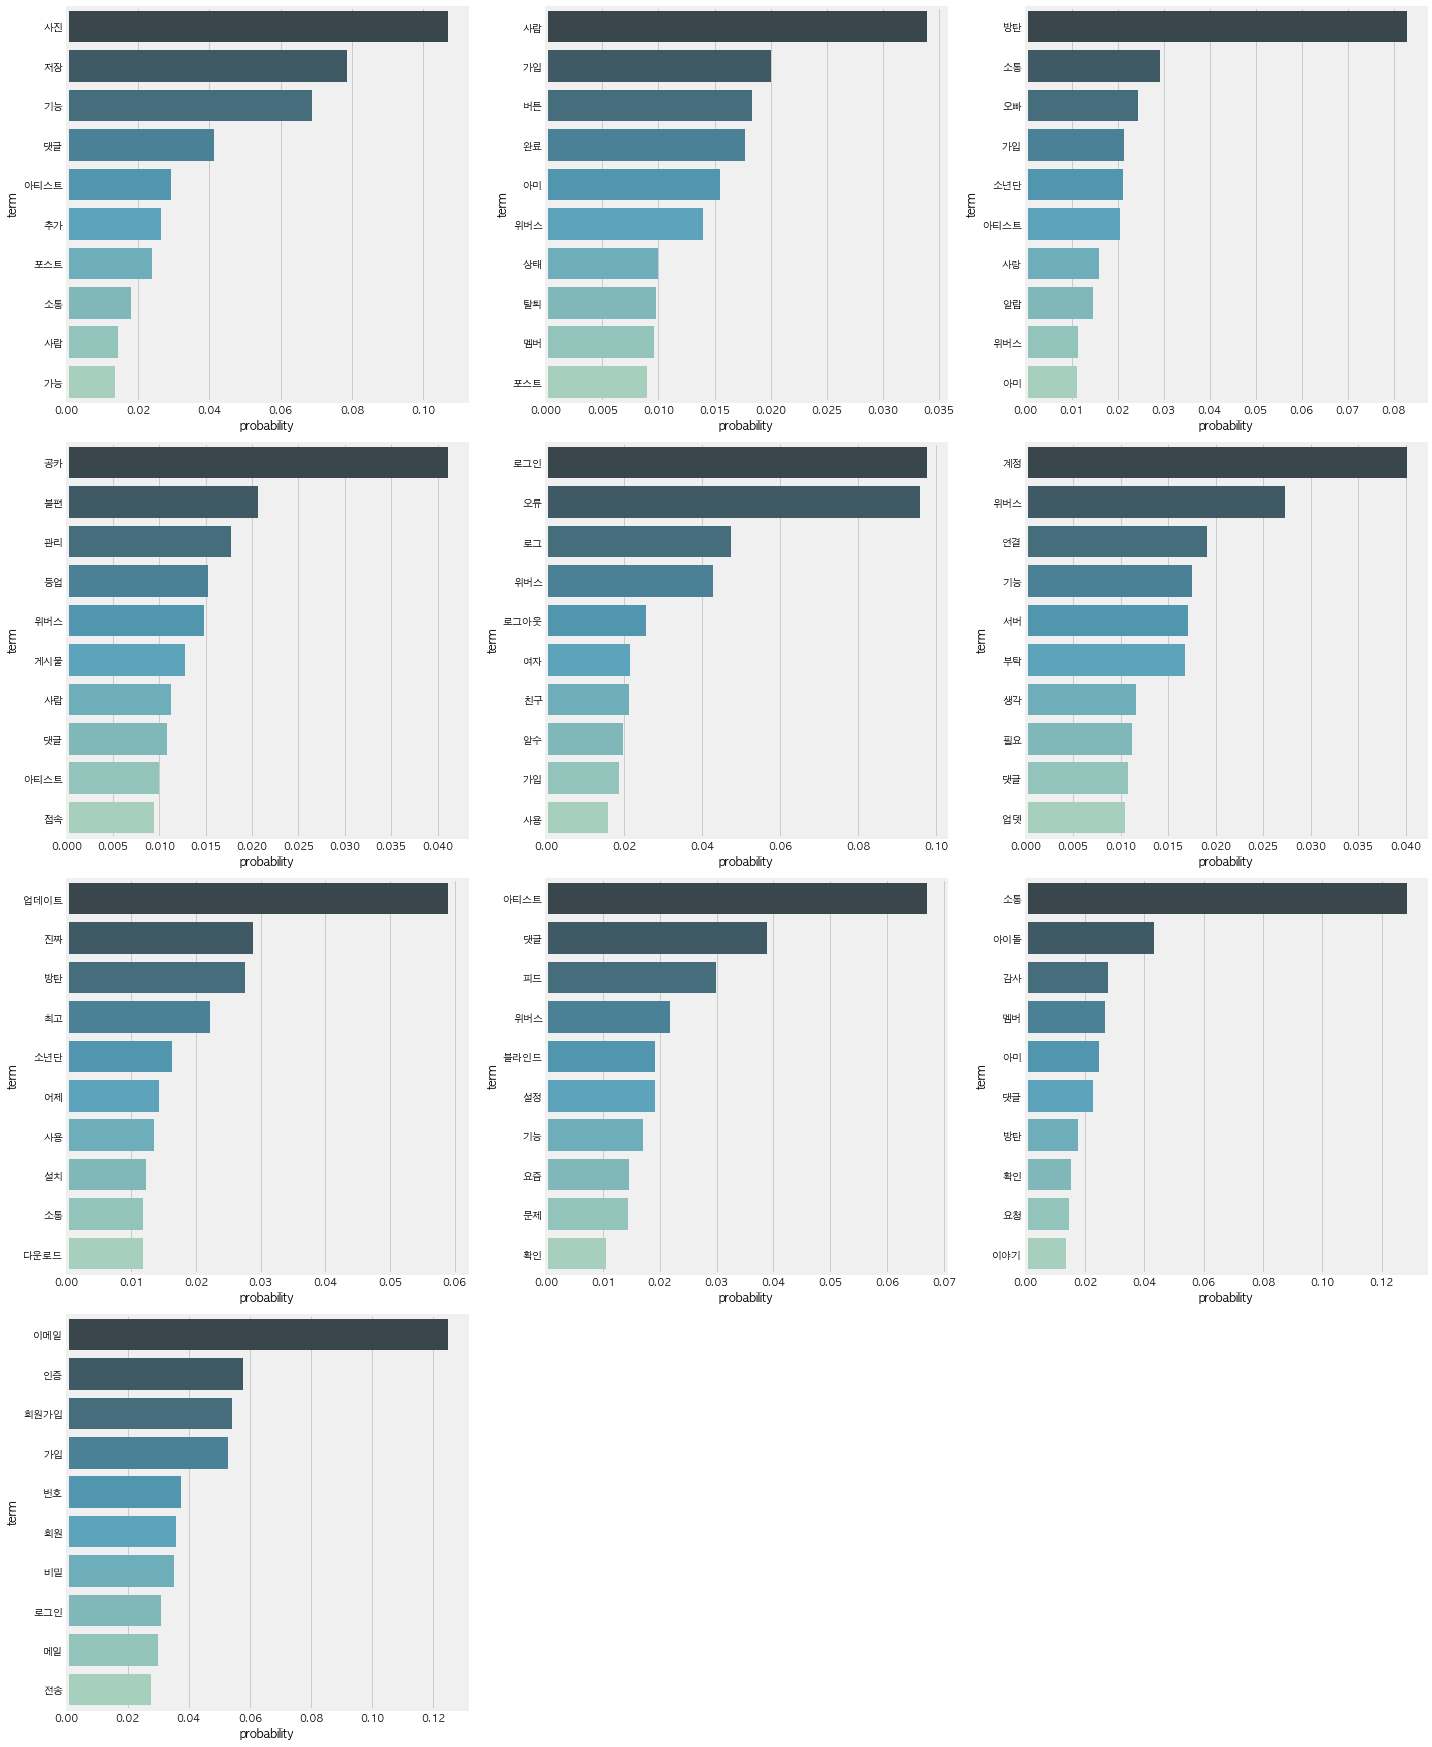

In [56]:
# run Topic modeling
make_lda_model_with_news(all_rating_extracted_user_comment_noun_list, 10, 'all_rating')

### 별점 2점 이하일 경우에 대한 분석

In [57]:
# get user_comment_noun_list of low rating reviews

low_rating_user_comment_list = arranged_user_review_df[arranged_user_review_df['user_app_rating'] <= 2]['user_comment'].tolist()
low_rating_extracted_user_comment_noun_list = execute_khaiii(low_rating_user_comment_list)

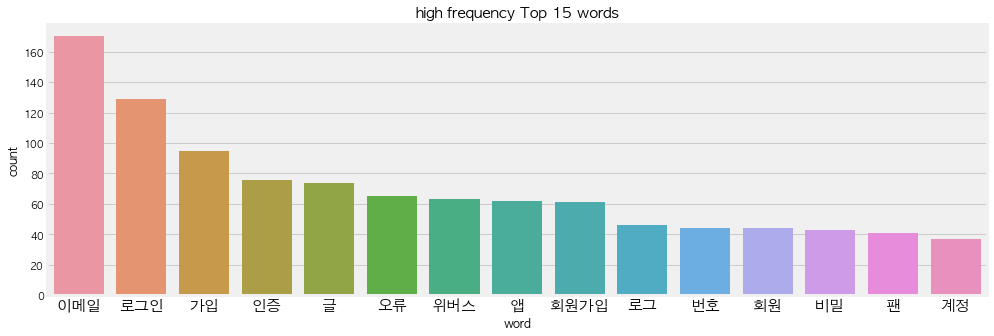

In [58]:
low_rating_word_count_df_new = get_dataframe_from_noun_list(low_rating_extracted_user_comment_noun_list)
draw_graph(low_rating_word_count_df_new)

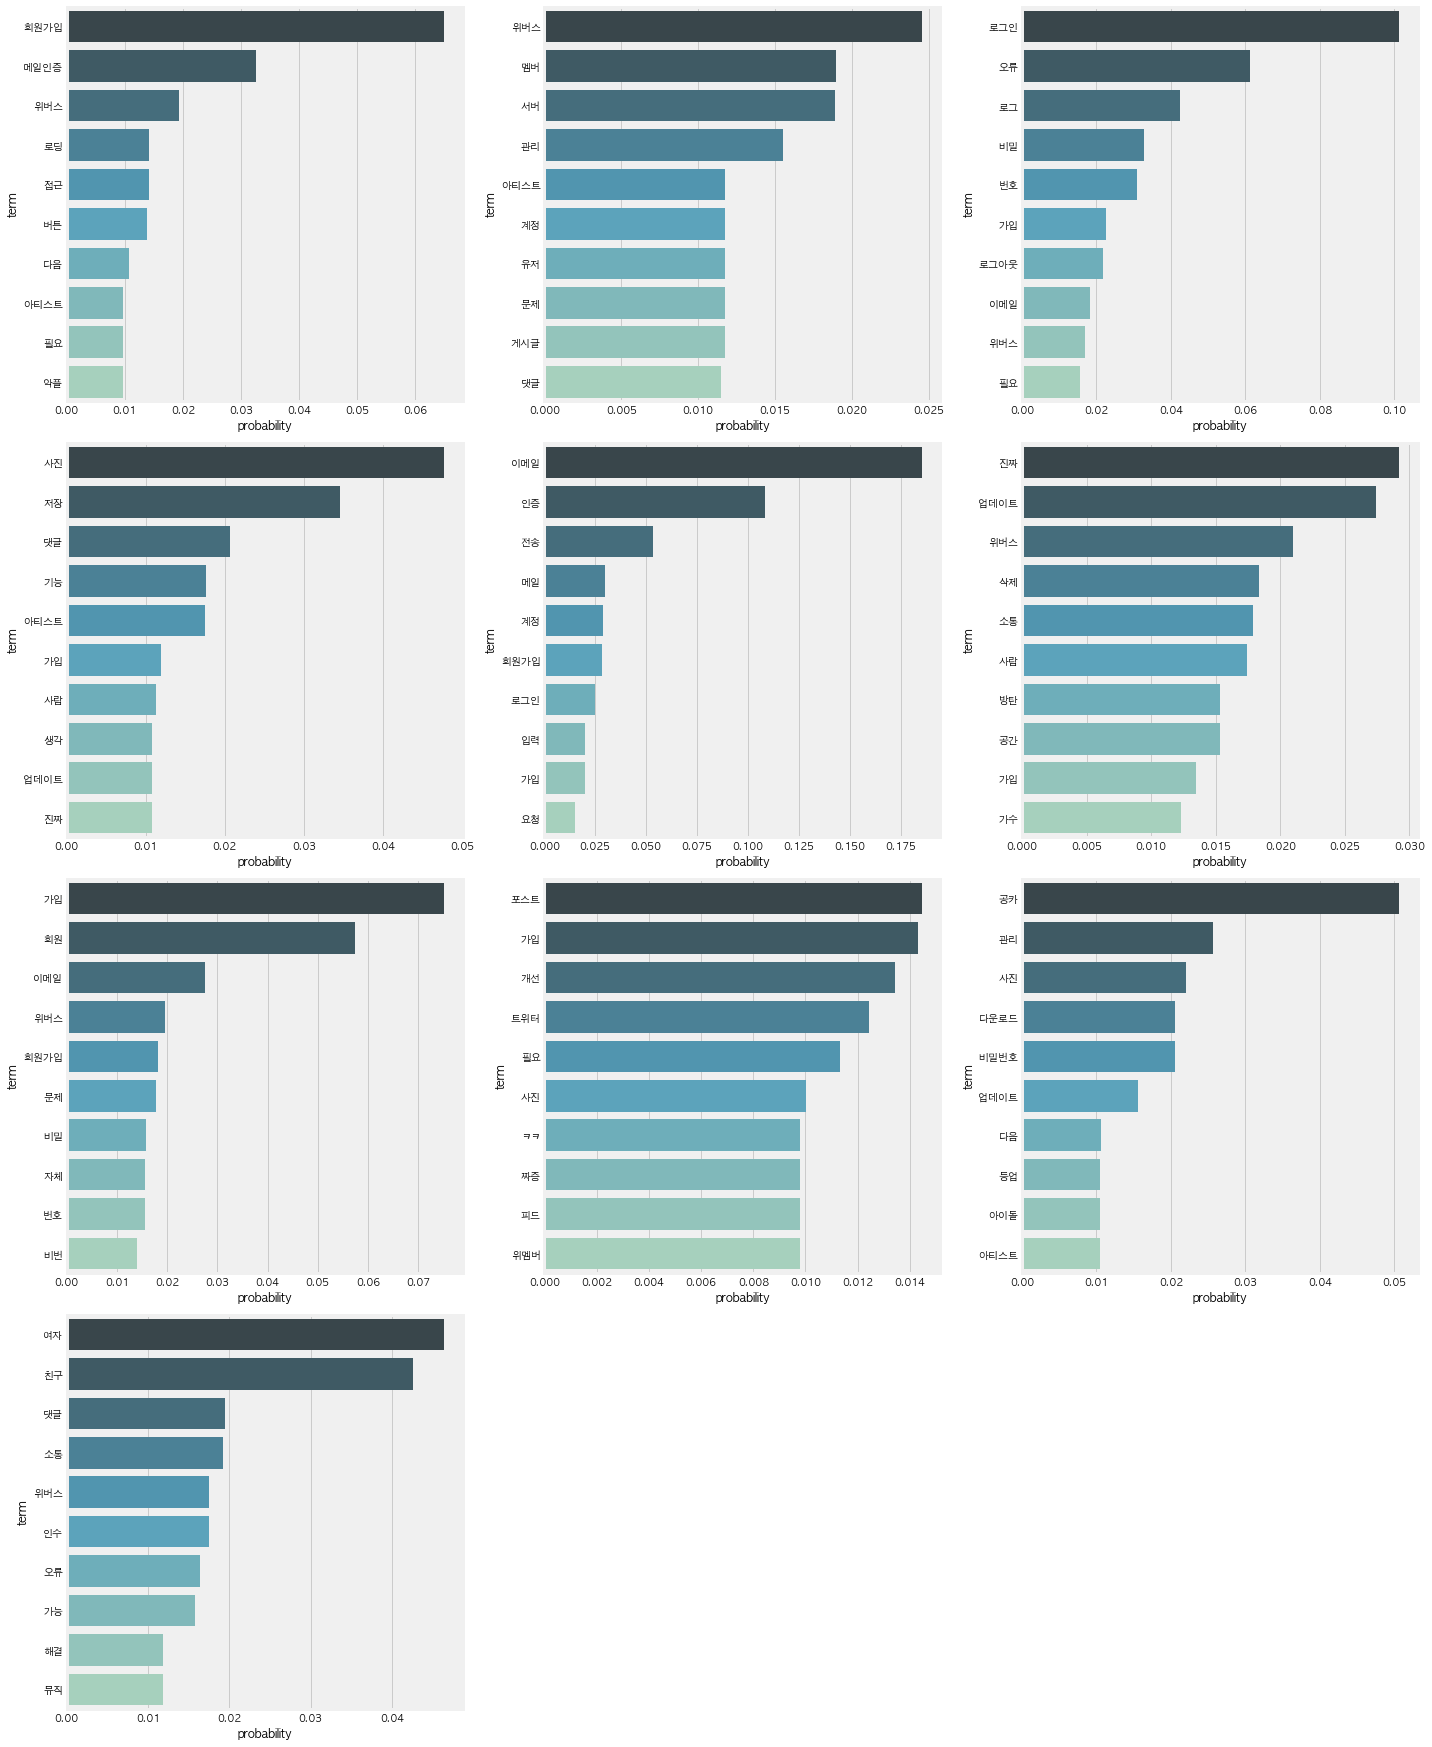

In [59]:
# run Topic modeling

make_lda_model_with_news(low_rating_extracted_user_comment_noun_list, 10, 'low_rating')